In [1]:
import warnings
warnings.simplefilter(action='ignore')
from focal_loss import SparseCategoricalFocalLoss
import pandas as pd
import tensorflow as tf
import glob
import math
import matplotlib.pyplot as plt
import json
import numpy as np
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import os
import tensorflow_io as tfio

In [2]:
def seed_it_all(seed=7):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()

In [3]:
ROWS_PER_FRAME = 543
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

#test_data  = load_relevant_data_subset('train_landmark_files/16069/100015657.parquet')

In [4]:
LIP = [
            61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
            291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
            78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
            95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]


In [5]:
class CFG:
    left_ROWS_per_frame = 21
    sequence_length = 20
    batch_size = 32
    face_ROWS_per_frame = 468
    lip_ROWS_per_frame = 40

labels  = json.load(open('sign_to_prediction_index_map.json','r'))
complete_df = pd.read_csv('train.csv')
complete_df = complete_df[complete_df['participant_id']!='37055']
from sklearn.model_selection import train_test_split
y = complete_df['sign']
train_df, test_df = train_test_split(complete_df, test_size=0.2,stratify=y)

In [6]:
def build_loader(with_labels=True):
    def load_video(video_path):
        #print('herer')
        video_df = tfio.IODataset.from_parquet(video_path)
        #video_df = pd.read_parquet(video_path, engine='pyarrow')
        #video_df.fillna(0,inplace=True)
        left_df = video_df[video_df.type=='left_hand']
        left_values = left_df[['x','y','z']].values
        left_values = left_values.reshape(-1,CFG.left_ROWS_per_frame,3)
        left_hand_array =  tf.image.resize(left_values, (CFG.sequence_length, CFG.left_ROWS_per_frame))
        right_df = video_df[video_df.type=='right_hand']
        right_values = right_df[['x','y','z']].values
        right_values = right_values.reshape(-1,CFG.left_ROWS_per_frame,3)
        right_hand_array =  tf.image.resize(right_values, (CFG.sequence_length, CFG.left_ROWS_per_frame))
        return [left_hand_array, right_hand_array]
    
    def load_video_with_labels(path, label):
        return load_video(path), labels[label]
    
    return load_video_with_labels if with_labels else load_video

In [7]:
class CustomData(tf.keras.utils.Sequence):
    def __init__(self,df,num_frames=20,batch_size=8,shuffle=True,\
                 labels_path='sign_to_prediction_index_map.json'):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_frames = num_frames
        self.labels  = json.load(open('sign_to_prediction_index_map.json','r'))
        self.on_epoch_end()
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self,index):
        batches = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        combined = np.zeros(shape=(self.batch_size,self.num_frames,\
                                        CFG.left_ROWS_per_frame+CFG.lip_ROWS_per_frame,3))
        labels = []
        for i,row_val in enumerate(batches):
            row = self.df.iloc[row_val]
            left_hand,lip = self.load_video(row['path'])
            combined[i,:,:21,:] = left_hand
            combined[i,:,21:,:] = lip
            labels.append(self.labels[row['sign']])
        return combined,np.asarray(labels)
            
    def load_video(self,video_path):
        video_df = pd.read_parquet(video_path, engine='pyarrow')
        #video_df.dropna(inplace=True)
        
        if video_df[video_df['type']=='left_hand']['x'].isna().mean() <= \
      video_df[video_df['type']=='right_hand']['x'].isna().mean():
            left_df = video_df[video_df.type=='left_hand']
            left_df.dropna(inplace=True)
            if len(left_df) != 0:
                left_values = left_df[['x','y','z']].values
                left_values = left_values.reshape(-1,CFG.left_ROWS_per_frame,3)
                left_hand_array =  tf.image.resize(left_values, (CFG.sequence_length, CFG.left_ROWS_per_frame))
            else:
                left_hand_array = tf.zeros(shape=(CFG.sequence_length, CFG.left_ROWS_per_frame,2),dtype=tf.float32)
        else:
            left_df = video_df[video_df.type=='right_hand']
            left_df.dropna(inplace=True)
            if len(left_df) != 0:
                left_values = left_df[['x','y','z']].values
                left_values = left_values.reshape(-1,CFG.left_ROWS_per_frame,3)
                left_values[:,:,:1] = np.max(left_values[:,:,:1]) - left_values[:,:,:1] 
                left_hand_array =  tf.image.resize(left_values, (CFG.sequence_length, CFG.left_ROWS_per_frame))
            else:
                left_hand_array = tf.zeros(shape=(CFG.sequence_length, CFG.left_ROWS_per_frame,3),dtype=tf.float32)
        
        face_df = video_df[video_df.type=='face']
        face_df.dropna(inplace=True)
        face_df = face_df[['x','y','z']].values
        face_df = face_df.reshape(-1,CFG.face_ROWS_per_frame,3)
        lip_values = face_df[:,LIP,:]
        if len(lip_values) != 0:
            lip_values_array =  tf.image.resize(lip_values, (CFG.sequence_length, CFG.lip_ROWS_per_frame))
        else:
            lip_values_array = tf.zeros(shape=(CFG.sequence_length, CFG.lip_ROWS_per_frame,3),dtype=tf.float32)
        
        return left_hand_array,lip_values_array
    
    def __len__(self):
        return len(self.df)//self.batch_size

In [8]:
train_datagen = CustomData(train_df,num_frames=CFG.sequence_length,batch_size=256)
test_datagen = CustomData(test_df,num_frames=CFG.sequence_length,batch_size=256)

In [12]:
all_data_x = []
all_data_y = []
for i in range(len(train_datagen)):
    x,y = train_datagen[i]
    all_data_x.extend(x)
    all_data_y.extend(y)

KeyboardInterrupt: 

In [12]:
np.save('X_train_20x61_left.npy', np.asarray(all_data_x))
np.save('y_train_20x61_left.npy', np.asarray(all_data_y))

In [21]:
def transformer_architecture():
    # Define the hyperparameters
    num_layers = 2
    d_model = 122
    num_heads = 4
    dff = 256
    dropout_rate = 0.2
    lips_input_shape = (20,40,2)
    hands_input_shape = (20,21,2)
    # Flatten the last two dimensions
    frames = tf.keras.layers.Input([20, 61, 3], dtype=tf.float32, name='frames')
    
    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,20, 61, 2])
    # LIPS
    lips = tf.slice(x, [0,0,20,0], [-1,20, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    lips_inputs = tf.reshape(lips, [-1, 20, 40*2])
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,0,0], [-1,20, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    hands_inputs = tf.reshape(left_hand, [-1, 20, 21*2])
    print(lips_inputs.shape,hands_inputs.shape)
    #lips_inputs = tf.keras.layers.Input(shape=lips_input_shape)
    #hands_inputs = tf.keras.layers.Input(shape=hands_input_shape)
    x1 = tf.keras.layers.Reshape((lips_input_shape[0], lips_input_shape[1]*lips_input_shape[2]))(lips_inputs)
    x2 = tf.keras.layers.Reshape((hands_input_shape[0], hands_input_shape[1]*hands_input_shape[2]))(hands_inputs)
    # Positional encoding
    x1 = PositionalEmbedding(20, 80, name="frame_position_embedding1")(x1)
    x2 = PositionalEmbedding(20, 42, name="frame_position_embedding2")(x2)
    #print(x1.shape)
    #pos_enc1 = tf.keras.layers.Embedding(lips_input_shape[1], 80)(tf.range(lips_input_shape[1]))
    #print(pos_enc1.shape)
    #pos_enc1 = tf.repeat(pos_enc1, 20, axis=0)
    #x1 = x1 + pos_enc1
    
#     pos_enc2 = tf.keras.layers.Embedding(hands_input_shape[1], d_model)(tf.range(hands_input_shape[1]))
#     pos_enc2 = tf.repeat(pos_enc2, hands_input_shape[0], axis=0)
#     x2 = x2 + pos_enc2
    print(x1.shape,x2.shape)
    x = tf.concat([x1, x2], axis=-1)
    # Transformer encoder
    print(x.shape)
    for i in range(num_layers):
        # Multi-head attention
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model)(x, x)
        attention_output = tf.keras.layers.Dropout(dropout_rate)(attention_output)
        x = tf.keras.layers.LayerNormalization(
            epsilon=1e-6)(x + attention_output)
        # Feedforward
        ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
        ])
        ffn_output = ffn(x)
        ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
        x = tf.keras.layers.LayerNormalization(
            epsilon=1e-6)(x + ffn_output)

    # Output layer
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x
    # Define the model
    model = tf.keras.Model(inputs=frames, outputs=outputs)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    # Print the model summary
    
    model.summary()
    model.compile(loss=loss, optimizer=optimizer, metrics='accuracy')
    return model

In [22]:
model = transformer_architecture()

(None, 20, 80) (None, 20, 42)
(None, 20, 80) (None, 20, 42)
(None, 20, 122)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 20, 61, 3)]  0           []                               
                                                                                                  
 tf.slice_2 (TFOpLambda)        (None, 20, 61, 2)    0           ['frames[0][0]']                 
                                                                                                  
 tf.slice_3 (TFOpLambda)        (None, 20, 40, 2)    0           ['tf.slice_2[0][0]']             
                                                                                                  
 tf.slice_4 (TFOpLambda)        (None, 20, 21, 2)    0           ['tf.slice_2[0][0]']             
                  

                                                                                                  
 dropout_3 (Dropout)            (None, 20, 122)      0           ['sequential_1[0][0]']           
                                                                                                  
 tf.__operators__.add_3 (TFOpLa  (None, 20, 122)     0           ['layer_normalization_2[0][0]',  
 mbda)                                                            'dropout_3[0][0]']              
                                                                                                  
 layer_normalization_3 (LayerNo  (None, 20, 122)     244         ['tf.__operators__.add_3[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 global_average_pooling1d (Glob  (None, 122)         0           ['layer_normalization_3[0][0]']  
 alAverage

In [11]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = tf.keras.layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [12]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 384

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

In [13]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = False
TRAIN_MODEL = True
# True: use 10% of participants as validation set
# False: use all data for training -> gives better LB result
USE_VAL = False

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250

INPUT_SIZE = 64

BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
N_EPOCHS = 100
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237
N_COLS = 61

In [14]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

# HAND_IDXS: 21, N_COLS: 66
LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


In [15]:
# Load Data
ROOT_DIR = '/home/sign_language/'
if USE_VAL:
    # Load Train
    X_train = np.load(f'{ROOT_DIR}/X_train.npy')
    y_train = np.load(f'{ROOT_DIR}/y_train.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
    # Load Val
    X_val = np.load(f'{ROOT_DIR}/X_val.npy')
    y_val = np.load(f'{ROOT_DIR}/y_val.npy')
    NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')
    # Define validation Data
    validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)
else:
    X_train = np.load(f'{ROOT_DIR}/X.npy')
    y_train = np.load(f'{ROOT_DIR}/y.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS.npy')
    validation_data = None

# Train 
# Val
if USE_VAL:
    print_shape_dtype([X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL], ['X_val', 'y_val', 'NON_EMPTY_FRAME_IDXS_VAL'])
# Sanity Check
print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

# NaN Values X_train: 0


100%|██████████| 40/40 [00:04<00:00,  8.98it/s]


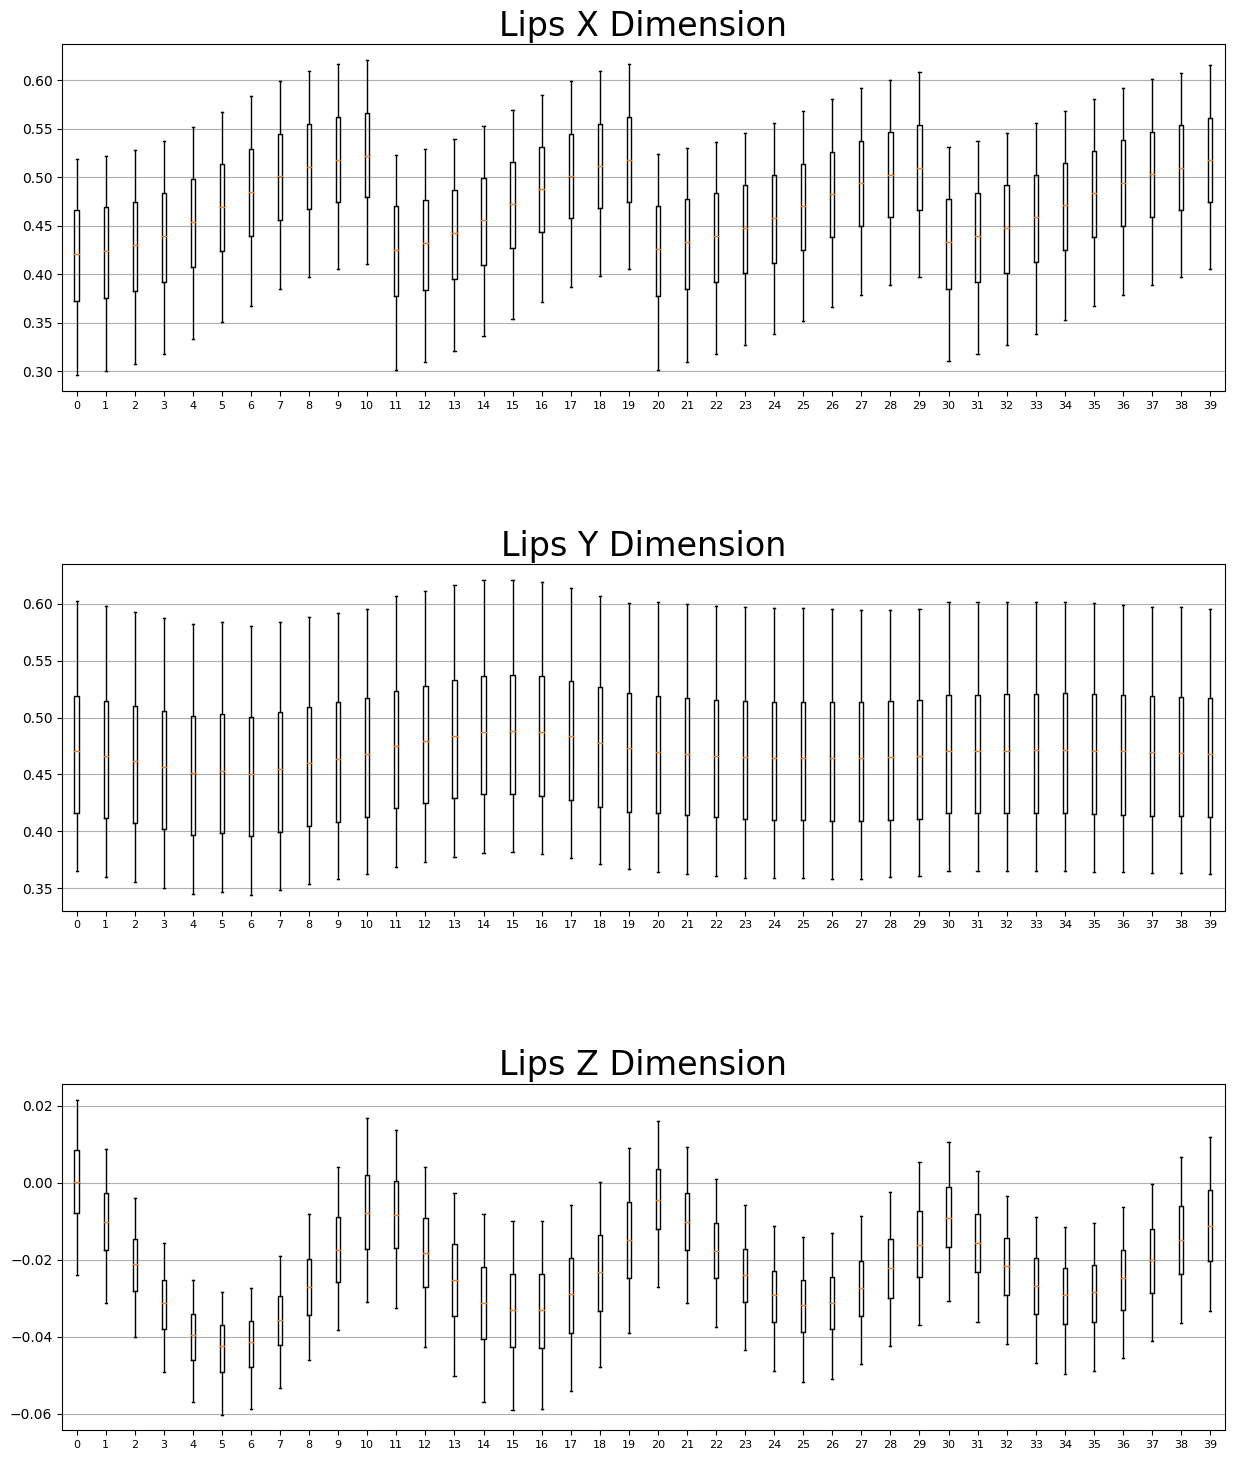

In [16]:
def get_lips_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T
    
    return LIPS_MEAN, LIPS_STD

LIPS_MEAN, LIPS_STD = get_lips_mean_std()

100%|██████████| 21/21 [00:01<00:00, 12.56it/s]


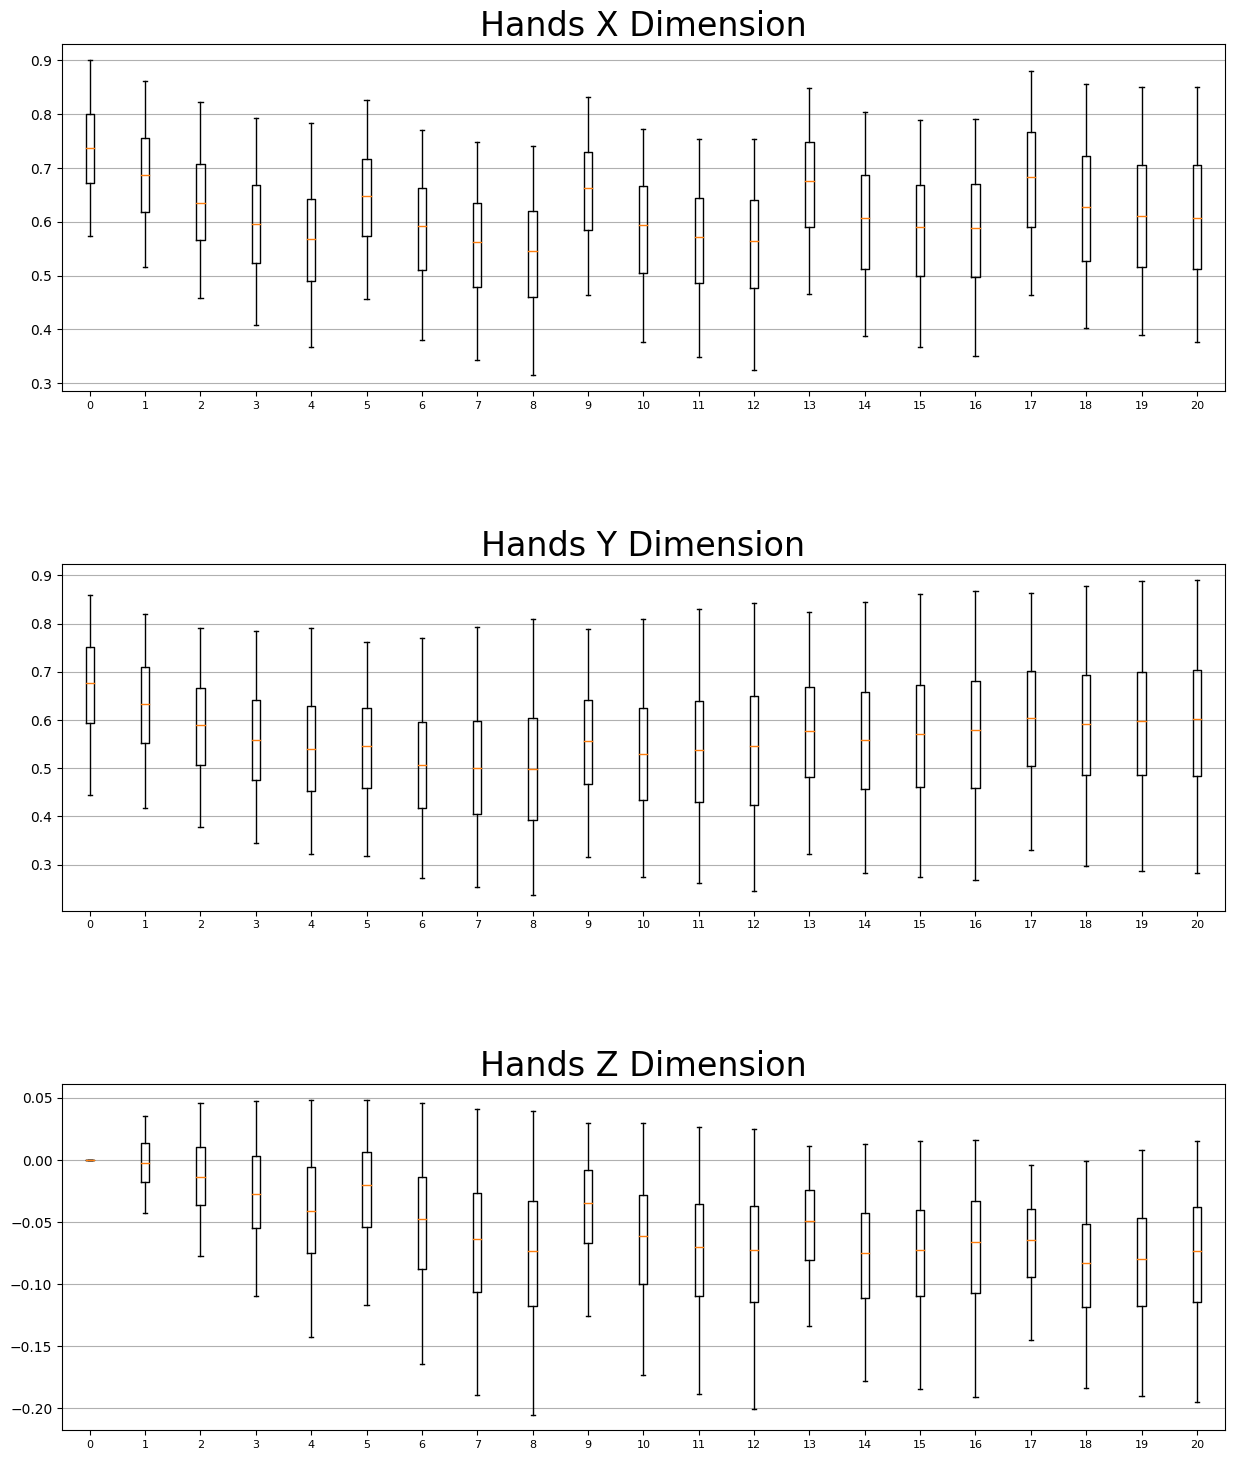

In [17]:
def get_left_right_hand_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
    
    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()

In [18]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

In [19]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

In [20]:
# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)


In [23]:
x_train = np.load('X_train_20x61_left.npy')
y_train = np.load('y_train_20x61_left.npy')
x_test = np.load('X_test_20x61_left.npy')
y_test = np.load('y_test_20x61_left.npy')

In [25]:
tf.keras.backend.clear_session()

# Get new fresh model
#model = transformer_architecture()
file_name = 'models/weights_041723_22_03_2.h5'
#model = tf.keras.models.load_model('models/041423_21_02.h5')

# Sanity Check
model.summary()

# Actual Training
history = model.fit(
        x=x_train,
        y=y_train,
        epochs=100,
        # Only used for validation data since training data is a generator
        batch_size=256,
        validation_data=(x_test,y_test),
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
            file_name,
            save_weights_only = True,
            save_best_only=True, 
            monitor="val_accuracy",
            mode="max",
            verbose = 1),
            lr_callback,
            WeightDecayCallback(),
        ],
        verbose = 1,
    )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 20, 61, 3)]  0           []                               
                                                                                                  
 tf.slice_2 (TFOpLambda)        (None, 20, 61, 2)    0           ['frames[0][0]']                 
                                                                                                  
 tf.slice_3 (TFOpLambda)        (None, 20, 40, 2)    0           ['tf.slice_2[0][0]']             
                                                                                                  
 tf.slice_4 (TFOpLambda)        (None, 20, 21, 2)    0           ['tf.slice_2[0][0]']             
                                                                                              

 dropout_3 (Dropout)            (None, 20, 122)      0           ['sequential_1[0][0]']           
                                                                                                  
 tf.__operators__.add_3 (TFOpLa  (None, 20, 122)     0           ['layer_normalization_2[0][0]',  
 mbda)                                                            'dropout_3[0][0]']              
                                                                                                  
 layer_normalization_3 (LayerNo  (None, 20, 122)     244         ['tf.__operators__.add_3[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 global_average_pooling1d (Glob  (None, 122)         0           ['layer_normalization_3[0][0]']  
 alAveragePooling1D)                                                                              
          


Epoch 15: LearningRateScheduler setting learning rate to 0.0009524135262330098.
learning rate: 9.52e-04, weight decay: 4.76e-05
Epoch 15/100
293/295 [============================>.] - ETA: 0s - loss: 0.5292 - accuracy: 0.8456
Epoch 15: val_accuracy did not improve from 0.73143
295/295 [==============================] - 5s 16ms/step - loss: 0.5296 - accuracy: 0.8455 - val_loss: 1.3042 - val_accuracy: 0.7278 - lr: 9.5241e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0009455032620941839.
learning rate: 9.46e-04, weight decay: 4.73e-05
Epoch 16/100
295/295 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.8473
Epoch 16: val_accuracy did not improve from 0.73143
295/295 [==============================] - 5s 16ms/step - loss: 0.5239 - accuracy: 0.8473 - val_loss: 1.3296 - val_accuracy: 0.7240 - lr: 9.4550e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.0009381533400219318.
learning rate: 9.38e-04, weight decay: 4.69e-05
Epoch 17/100
29

295/295 [==============================] - 5s 16ms/step - loss: 0.2546 - accuracy: 0.9258 - val_loss: 1.3857 - val_accuracy: 0.7519 - lr: 5.0000e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.00048429462046093585.
learning rate: 4.84e-04, weight decay: 2.42e-05
Epoch 52/100
293/295 [============================>.] - ETA: 0s - loss: 0.2473 - accuracy: 0.9290
Epoch 52: val_accuracy did not improve from 0.75187
295/295 [==============================] - 5s 17ms/step - loss: 0.2474 - accuracy: 0.9289 - val_loss: 1.3741 - val_accuracy: 0.7508 - lr: 4.8429e-04

Epoch 53: LearningRateScheduler setting learning rate to 0.0004686047402353433.
learning rate: 4.69e-04, weight decay: 2.34e-05
Epoch 53/100
293/295 [============================>.] - ETA: 0s - loss: 0.2393 - accuracy: 0.9318
Epoch 53: val_accuracy improved from 0.75187 to 0.75235, saving model to models/weights_041723_22_03_2.h5
295/295 [==============================] - 5s 17ms/step - loss: 0.2395 - accuracy: 0.9316


Epoch 70: LearningRateScheduler setting learning rate to 0.0002189583110739348.
learning rate: 2.19e-04, weight decay: 1.09e-05
Epoch 70/100
295/295 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9682
Epoch 70: val_accuracy improved from 0.76043 to 0.76183, saving model to models/weights_041723_22_03_2.h5
295/295 [==============================] - 4s 15ms/step - loss: 0.1302 - accuracy: 0.9682 - val_loss: 1.4237 - val_accuracy: 0.7618 - lr: 2.1896e-04

Epoch 71: LearningRateScheduler setting learning rate to 0.00020610737385376348.
learning rate: 2.06e-04, weight decay: 1.03e-05
Epoch 71/100
293/295 [============================>.] - ETA: 0s - loss: 0.1263 - accuracy: 0.9696
Epoch 71: val_accuracy did not improve from 0.76183
295/295 [==============================] - 5s 16ms/step - loss: 0.1263 - accuracy: 0.9697 - val_loss: 1.4269 - val_accuracy: 0.7605 - lr: 2.0611e-04

Epoch 72: LearningRateScheduler setting learning rate to 0.00019354647317351188.
learnin


Epoch 88: LearningRateScheduler setting learning rate to 4.112268715800943e-05.
learning rate: 4.11e-05, weight decay: 2.06e-06
Epoch 88/100
292/295 [============================>.] - ETA: 0s - loss: 0.0696 - accuracy: 0.9885
Epoch 88: val_accuracy did not improve from 0.76910
295/295 [==============================] - 4s 15ms/step - loss: 0.0698 - accuracy: 0.9885 - val_loss: 1.4528 - val_accuracy: 0.7674 - lr: 4.1123e-05

Epoch 89: LearningRateScheduler setting learning rate to 3.5111757055874326e-05.
learning rate: 3.51e-05, weight decay: 1.76e-06
Epoch 89/100
294/295 [============================>.] - ETA: 0s - loss: 0.0685 - accuracy: 0.9888
Epoch 89: val_accuracy did not improve from 0.76910
295/295 [==============================] - 5s 17ms/step - loss: 0.0685 - accuracy: 0.9888 - val_loss: 1.4541 - val_accuracy: 0.7683 - lr: 3.5112e-05

Epoch 90: LearningRateScheduler setting learning rate to 2.9559615522887274e-05.
learning rate: 2.96e-05, weight decay: 1.48e-06
Epoch 90/100


In [54]:
model.save_weights('models/weights_041423_21_02.h5')

In [55]:
new_model = get_model()
new_model.load_weights('models/weights_041423_21_02.h5')

In [22]:
model.load_weights('models/weights_041723_22_03.h5')

In [24]:
pred = model.predict(x=x_test)

584/584 [==============================] - 3s 4ms/step


In [27]:
def read_json_file(file_path):
    """Read a JSON file and parse it into a Python object.

    Args:
        file_path (str): The path to the JSON file to read.

    Returns:
        dict: A dictionary object representing the JSON data.
        
    Raises:
        FileNotFoundError: If the specified file path does not exist.
        ValueError: If the specified file path does not contain valid JSON data.
    """
    try:
        # Open the file and load the JSON data into a Python object
        with open(file_path, 'r') as file:
            json_data = json.load(file)
        return json_data
    except FileNotFoundError:
        # Raise an error if the file path does not exist
        raise FileNotFoundError(f"File not found: {file_path}")
    except ValueError:
        # Raise an error if the file does not contain valid JSON data
        raise ValueError(f"Invalid JSON data in file: {file_path}")
p2s_map = {v:k for k,v in read_json_file("sign_to_prediction_index_map.json").items()}
encoder = lambda x: s2p_map.get(x.lower())
decoder = lambda x: p2s_map.get(x)

In [29]:
preds = [decoder(np.argmax(i, axis=-1)) for i in pred]

In [32]:
labels = [decoder(i) for i in y_test]

In [33]:
cnt = 0
for i , j in zip(preds,labels):
    if i == j:
        cnt+=1
print(cnt/len(preds)) 

0.7688356164383562
